[*********************100%***********************]  1 of 1 completed

[WARN] CSV not found for AAPL. Falling back to yfinance.
[INFO] Downloading data for AAPL from yfinance
[INFO] Data loaded for AAPL: 1258 rows


<Figure size 1200x600 with 0 Axes>

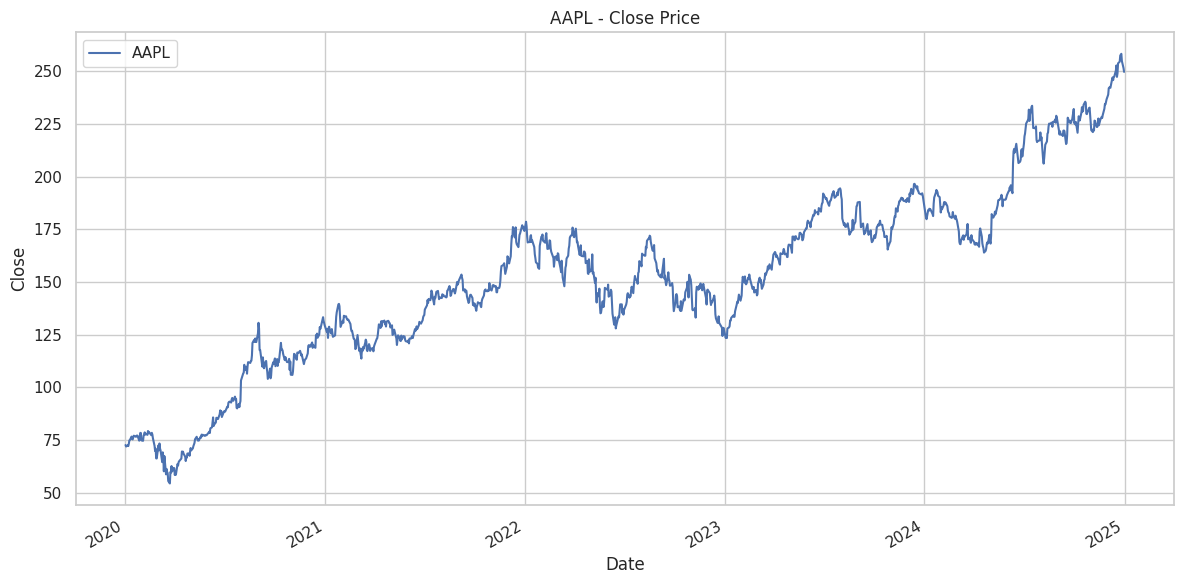

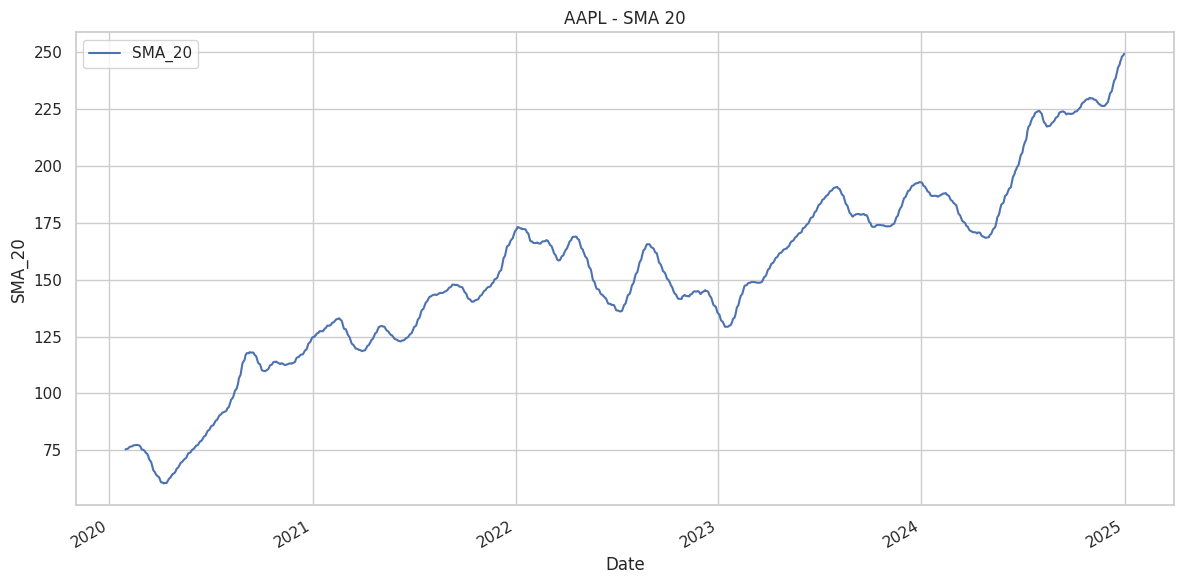

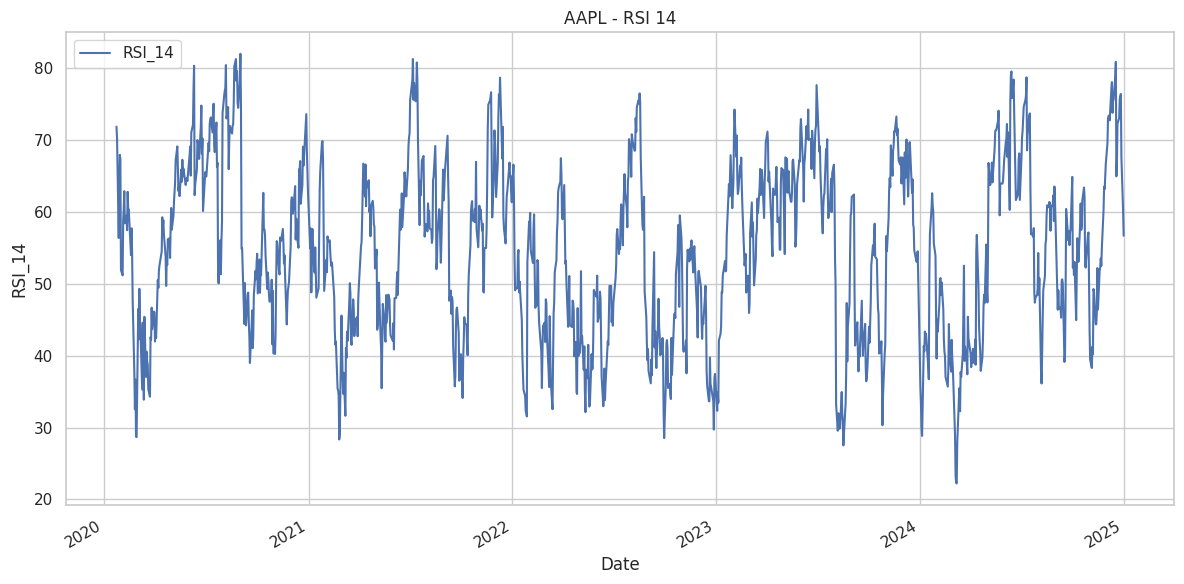

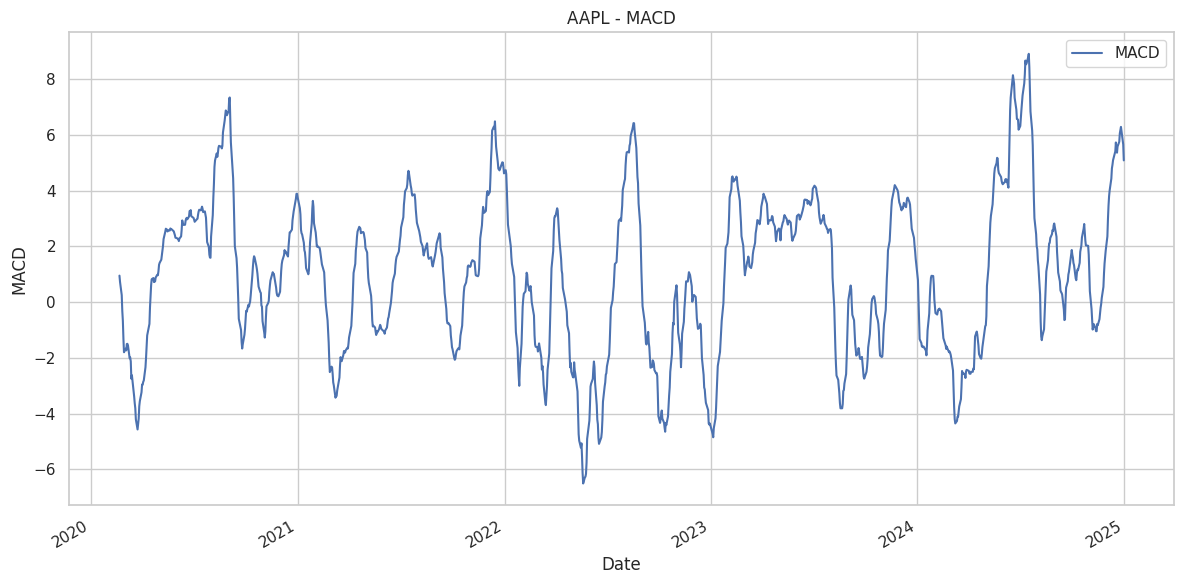

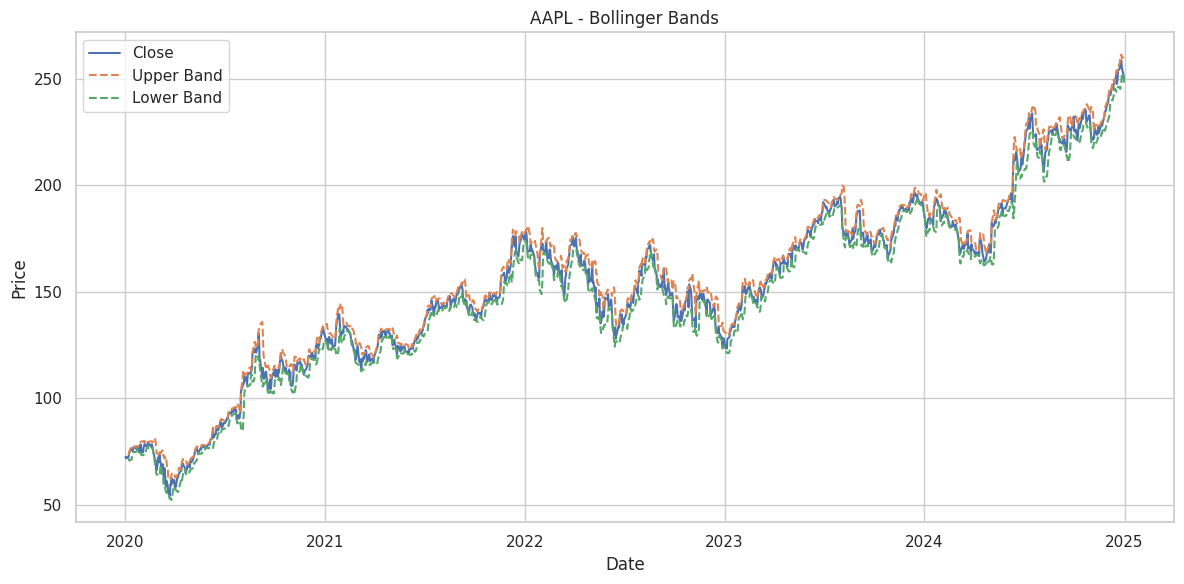

[*********************100%***********************]  1 of 1 completed

Analysis complete for AAPL. Outputs in output/task2/AAPL
[WARN] CSV not found for MSFT. Falling back to yfinance.
[INFO] Downloading data for MSFT from yfinance
[INFO] Data loaded for MSFT: 1258 rows


<Figure size 1200x600 with 0 Axes>

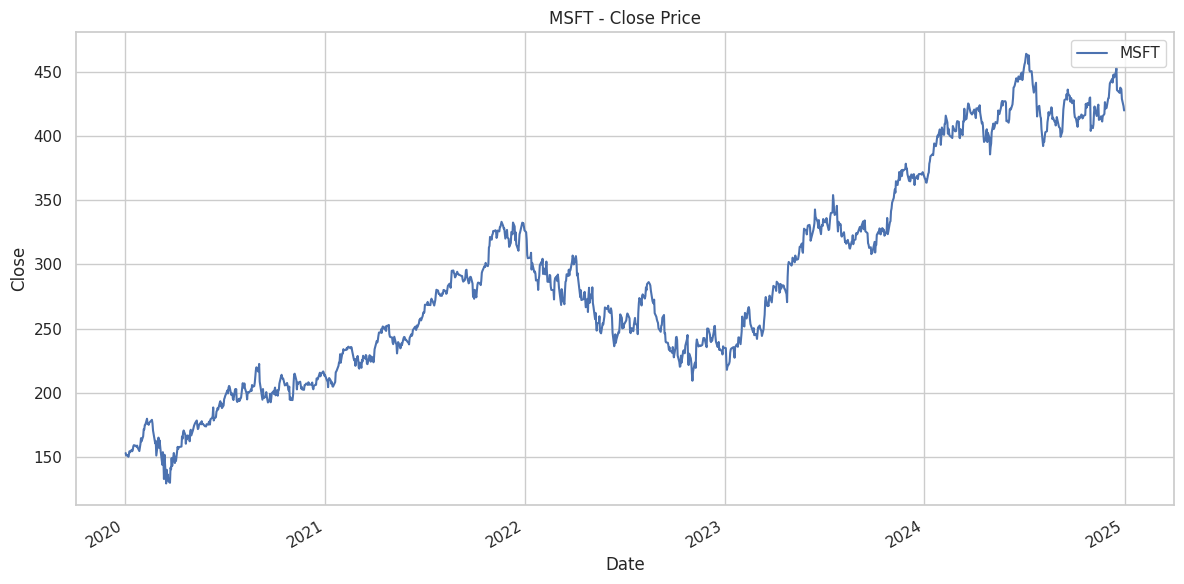

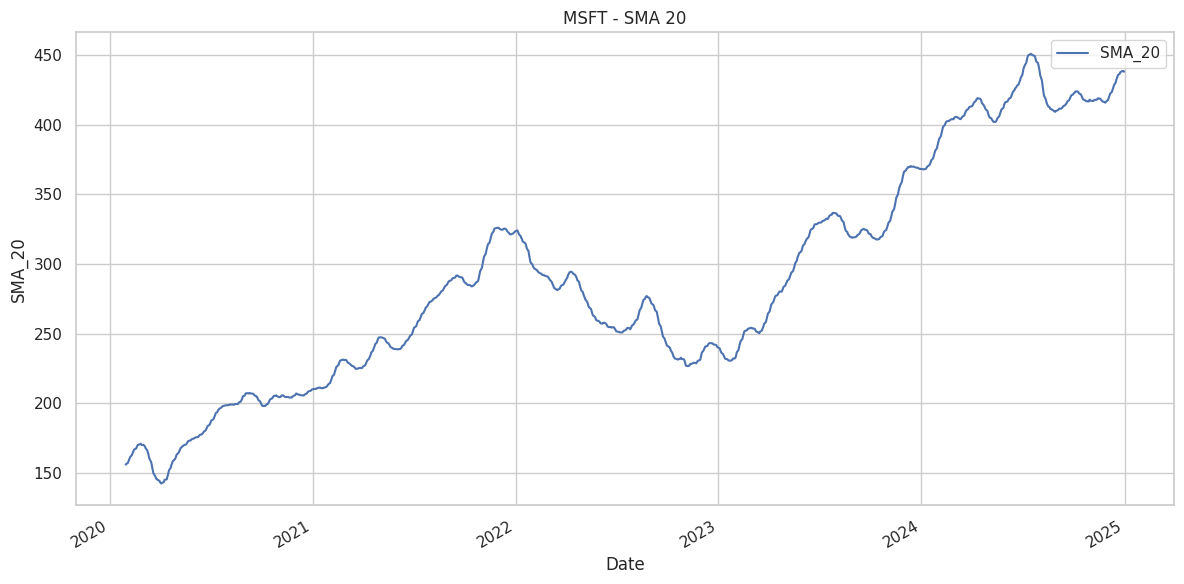

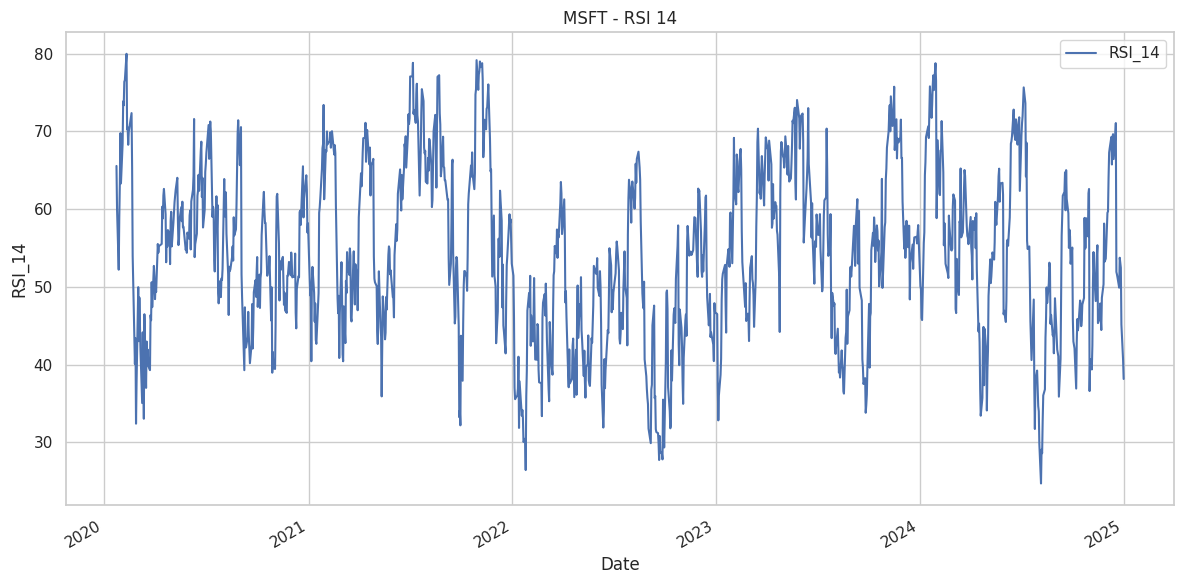

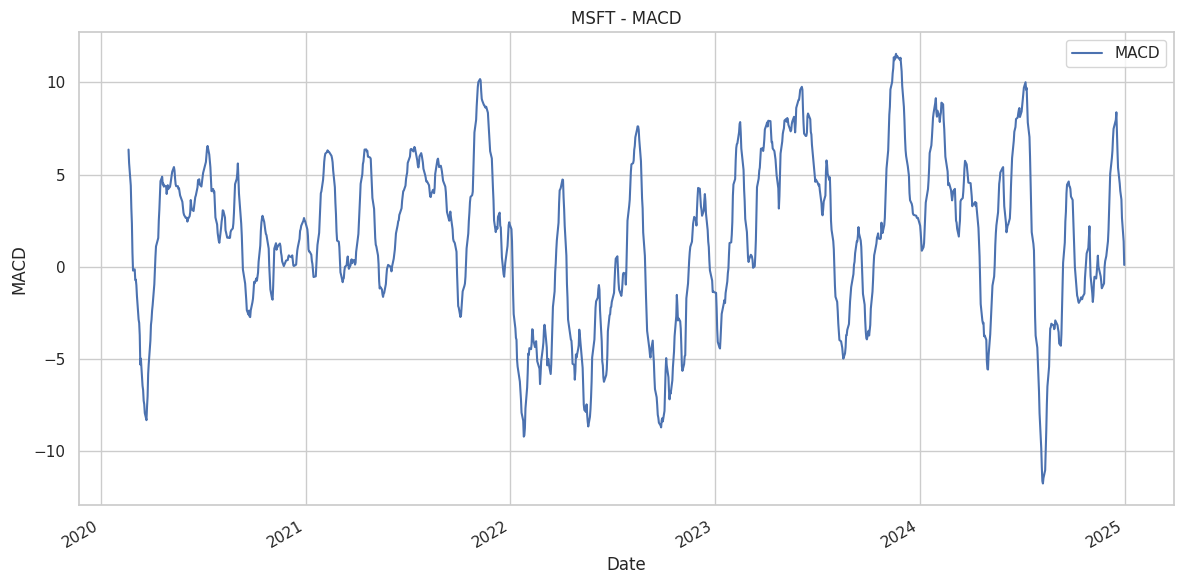

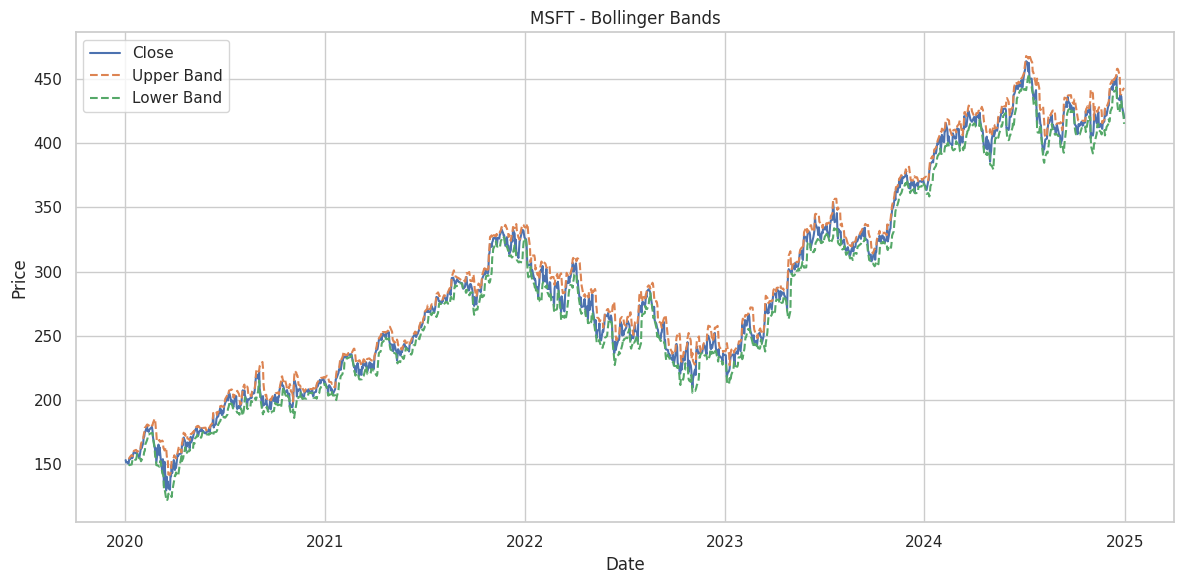

[*********************100%***********************]  1 of 1 completed

Analysis complete for MSFT. Outputs in output/task2/MSFT
[WARN] CSV not found for GOOG. Falling back to yfinance.
[INFO] Downloading data for GOOG from yfinance
[INFO] Data loaded for GOOG: 1258 rows


<Figure size 1200x600 with 0 Axes>

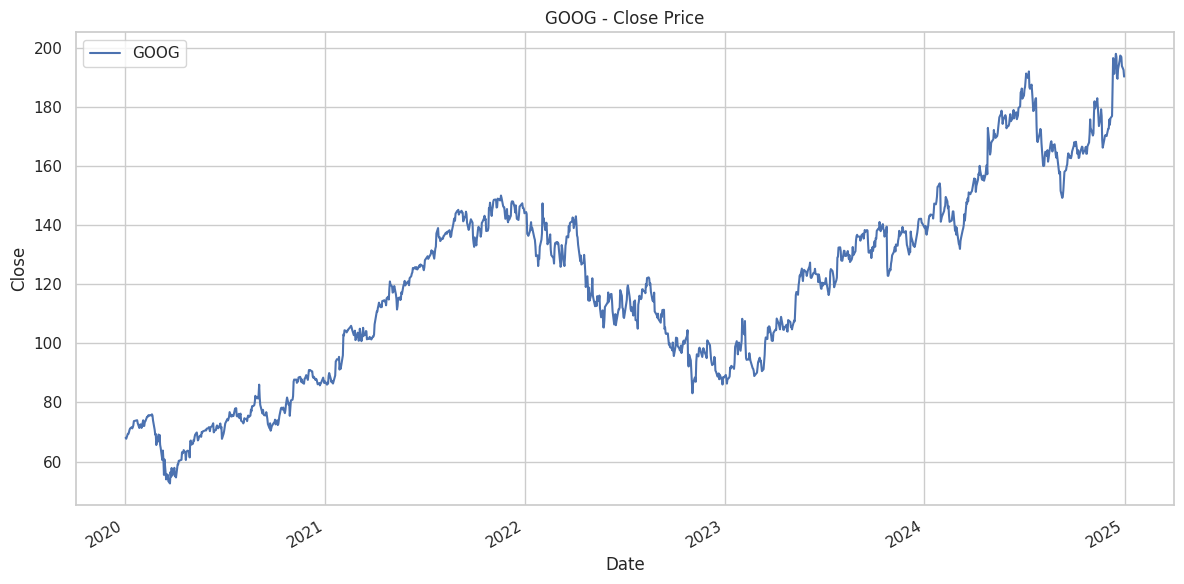

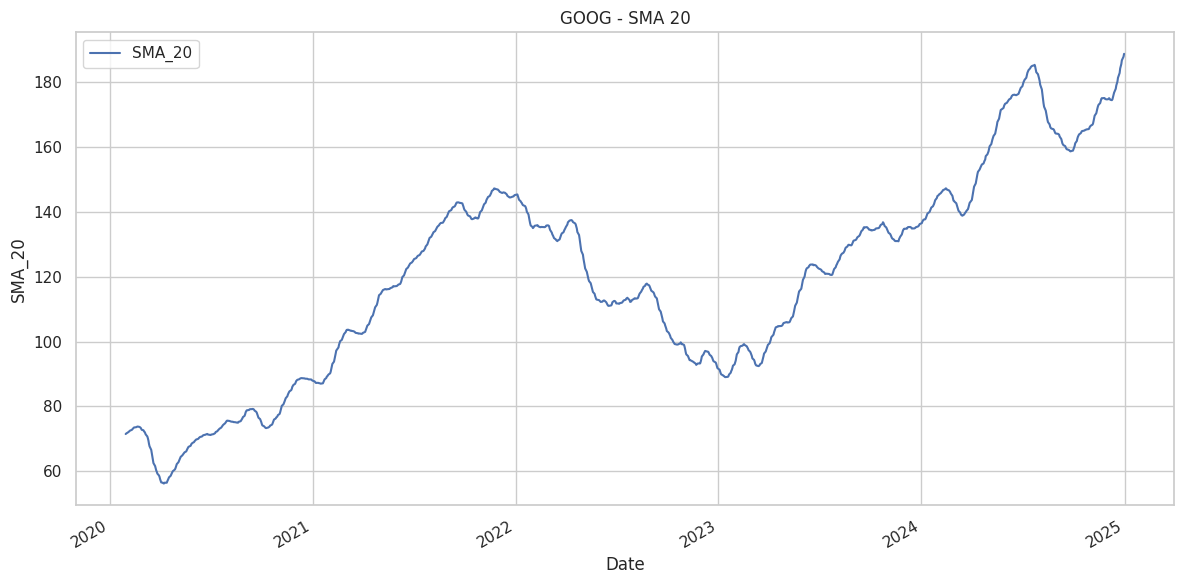

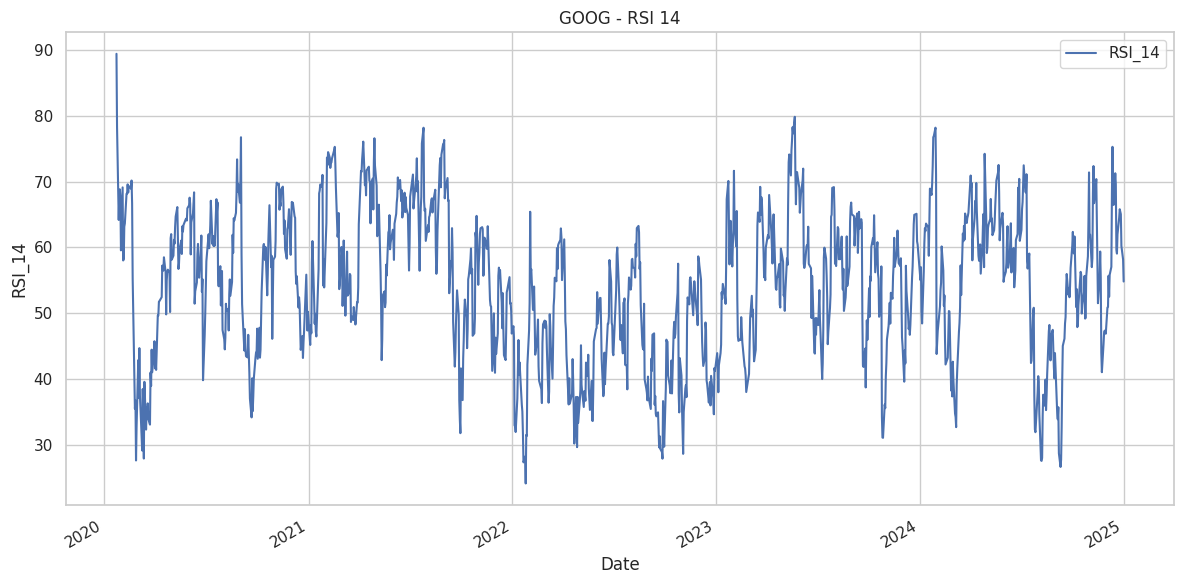

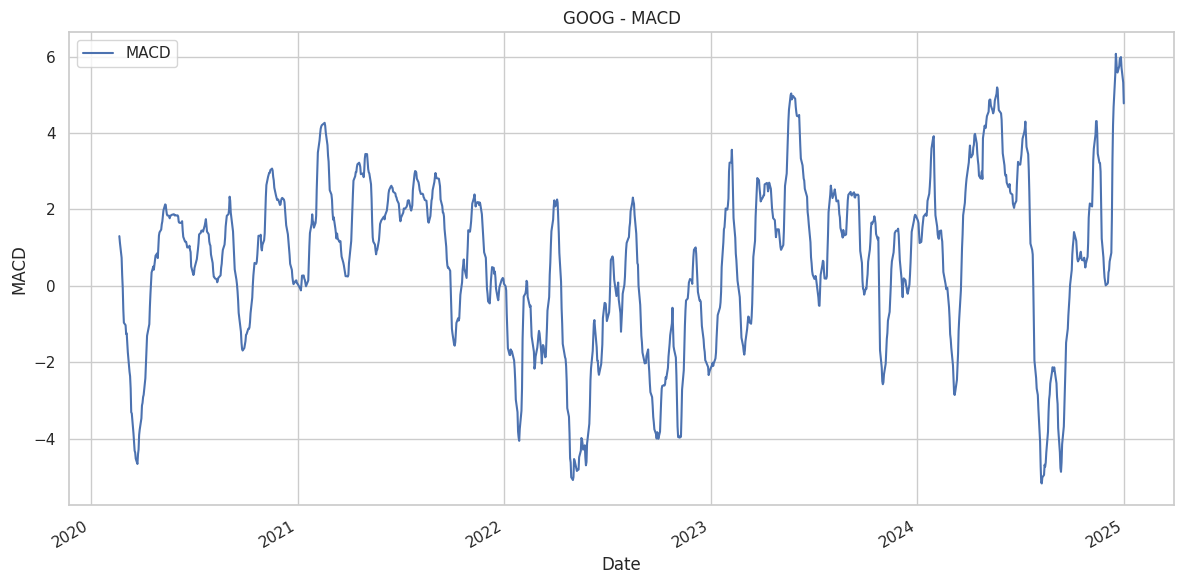

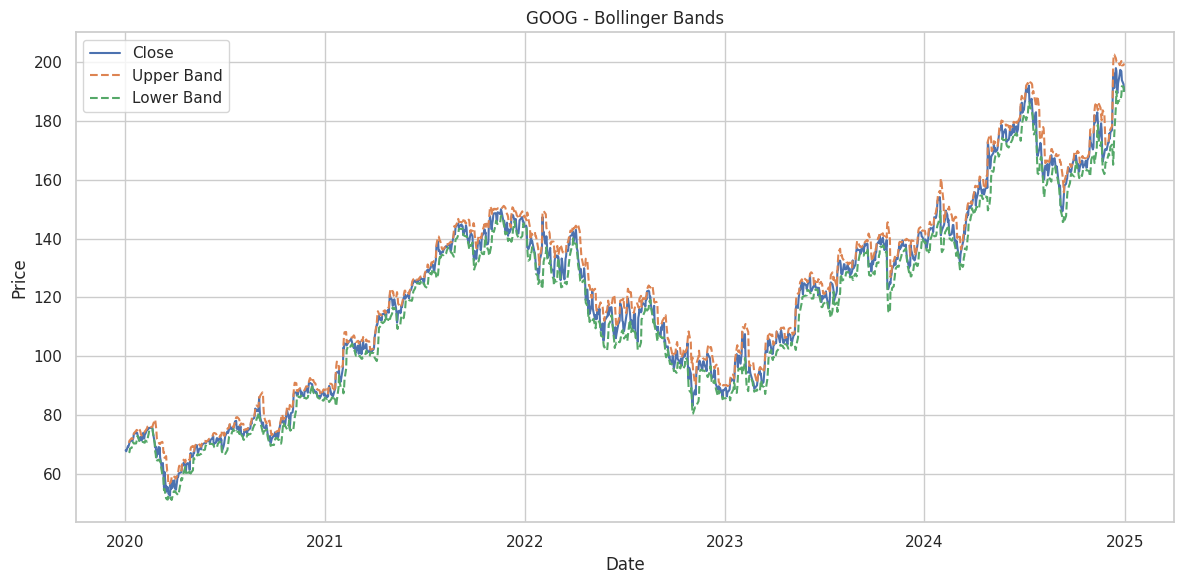

Analysis complete for GOOG. Outputs in output/task2/GOOG


In [ ]:
import os
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import talib

try:
    import pynance as pn
    HAS_PYNANCE = True
except ImportError:
    HAS_PYNANCE = False

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


class StockAnalyzer:
    def __init__(self, ticker: str, base_output_dir: str = "output/task2", csv_file: str = None):
        self.ticker = ticker.upper()
        self.output_dir = os.path.join(base_output_dir, self.ticker)
        os.makedirs(self.output_dir, exist_ok=True)
        self.csv_file = csv_file
        self.df = None


    def load_data(self, start: str = "2020-01-01", end: str = "2025-01-01"):
        if self.csv_file and os.path.exists(self.csv_file):
            print(f"[INFO] Loading CSV for {self.ticker} from {self.csv_file}")
            df = pd.read_csv(self.csv_file, parse_dates=["Date"])
            df.set_index("Date", inplace=True)
        else:
            print(f"[INFO] Downloading data for {self.ticker} from yfinance")
            df = yf.download(self.ticker, start=start, end=end)

        df.dropna(inplace=True)
        df.sort_index(inplace=True)
        self.df = df
        print(f"[INFO] Data loaded for {self.ticker}: {len(df)} rows")

    def compute_indicators(self):
        df = self.df
    
        close = df['Close'].values.flatten()
        high = df['High'].values.flatten()
        low = df['Low'].values.flatten()
    
        df['SMA_20'] = talib.SMA(close, timeperiod=20)
        df['RSI_14'] = talib.RSI(close, timeperiod=14)
    
        macd, macd_signal, macd_hist = talib.MACD(close)
        df['MACD'] = macd
        df['MACD_Signal'] = macd_signal
        df['MACD_Hist'] = macd_hist
    
        upper, middle, lower = talib.BBANDS(close)
        df['BB_Upper'] = upper
        df['BB_Middle'] = middle
        df['BB_Lower'] = lower
    
        self.df = df


    def plot(self, column: str, title: str, file: str):
        plt.figure()
        self.df[column].plot(label=column)
        plt.title(f"{self.ticker} - {title}")
        plt.xlabel("Date")
        plt.ylabel(column)
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, file))
        plt.show()
        plt.close()

    def plot_all(self):
        self.plot("Close", "Close Price", "close.png")
        self.plot("SMA_20", "SMA 20", "sma_20.png")
        self.plot("RSI_14", "RSI 14", "rsi.png")
        self.plot("MACD", "MACD", "macd.png")

        # Bollinger Bands
        plt.figure()
        plt.plot(self.df['Close'], label='Close')
        plt.plot(self.df['BB_Upper'], '--', label='Upper Band')
        plt.plot(self.df['BB_Lower'], '--', label='Lower Band')
        plt.title(f"{self.ticker} - Bollinger Bands")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, "bollinger_bands.png"))
        plt.show()
        plt.close()

        # plt.close('all')

    def run(self):
        self.load_data()
        self.compute_indicators()
        self.plot_all()
        print(f"Analysis complete for {self.ticker}. Outputs in {self.output_dir}")


def run_for_multiple_tickers(ticker_list, csv_dir: str = "."):
    tickers_found = []

    for ticker in ticker_list:
        csv_file = os.path.join(csv_dir, f"{ticker.upper()}_historical_data.csv")
        if not os.path.exists(csv_file):
            print(f"[WARN] CSV not found for {ticker}. Falling back to yfinance.")
            csv_file = None
        else:
            print(f"[INFO] Found local CSV for {ticker}.")

        try:
            analyzer = StockAnalyzer(ticker, csv_file=csv_file)
            analyzer.run()
            tickers_found.append(ticker)
        except Exception as e:
            print(f"[ERROR] Failed to process {ticker}: {e}")

    if HAS_PYNANCE and tickers_found:
        print("\n[INFO] Portfolio Summary (PyNance):")
        try:
            portfolio = pn.portfolio(tickers_found)
            print(portfolio.summary())
            portfolio.plot_value()
        except Exception as e:
            print(f"[ERROR] PyNance portfolio failed: {e}")


if __name__ == "__main__":
    tickers_to_analyze = ["AAPL", "MSFT", "GOOG"]
    run_for_multiple_tickers(tickers_to_analyze, csv_dir=".")
